In [6]:
!pip install -q -U --no-cache-dir gdown --pre

In [1]:
import torch
import numpy as np

from matplotlib import pyplot as plt

from model import Model


/home/tgieruc/miniconda3/envs/noise2noise/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
!gdown 1bL4nZBwNs68WAuix3cq-LJZ7QrNIYWH6 # train data
!gdown 12nFadfp-uyiE8xtc3wFl9sNBZ_8EpT6m # val data
!gdown 1JWUiX3jMr593zftQsp7YhHZSjN7xT3vG # pretrained weights

Downloading...
From: https://drive.google.com/uc?id=1bL4nZBwNs68WAuix3cq-LJZ7QrNIYWH6
To: /home/tgieruc/git/Noise2Noise_PyTorch/train_data.pkl
100%|████████████████████████████████████████| 307M/307M [00:03<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12nFadfp-uyiE8xtc3wFl9sNBZ_8EpT6m
To: /home/tgieruc/git/Noise2Noise_PyTorch/val_data.pkl
100%|██████████████████████████████████████| 6.14M/6.14M [00:00<00:00, 49.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JWUiX3jMr593zftQsp7YhHZSjN7xT3vG
To: /home/tgieruc/git/Noise2Noise_PyTorch/model_pytorch.pth
100%|██████████████████████████████████████| 3.97M/3.97M [00:00<00:00, 34.8MB/s]


In [23]:
def display_rgb(img):
    plt.imshow(img.permute(1,2,0))
    plt.show()

def psnr_eval(model, noised, ground_truth, must_randomize=True):
    def psnr(denoised, ground_truth):
        mse = torch.mean((denoised.cpu() - ground_truth.cpu()) ** 2)
        return -10 * torch.log10(mse + 10 ** -8)
    clean_imgs = ground_truth.clone()
    noised = noised.float()
    ground_truth = ground_truth.float()

    denoised = model.predict(noised) / 255

    psnr_result = psnr(denoised, (ground_truth / 255)).item()
    print(f'PSNR result: {psnr_result}dB')

    nb_images = 3

    f, axarr = plt.subplots(nb_images, 3)

    if must_randomize:
        nb_index = np.random.choice(len(noised), nb_images)
    else:
        nb_index = np.arange(nb_images)
    axarr[0, 0].set_title("Noisy Images")
    axarr[0, 1].set_title("Denoised")
    axarr[0, 2].set_title("Ground Truth")

    for i, index in enumerate(nb_index):
        axarr[i, 0].imshow(noised[index].permute(1,2,0).int())
        axarr[i,0].get_yaxis().set_visible(False)
        axarr[i,0].get_xaxis().set_visible(False)
        axarr[i, 1].imshow(denoised[index].cpu().detach().permute(1,2,0))
        axarr[i, 1].get_yaxis().set_visible(False)
        axarr[i, 1].get_xaxis().set_visible(False)
        axarr[i, 2].imshow(clean_imgs[index].permute(1,2,0))
        axarr[i, 2].get_yaxis().set_visible(False)
        axarr[i, 2].get_xaxis().set_visible(False)
    plt.show()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'The model will be loaded on the {"GPU" if device == "cuda" else "cpu"}.')

noisy_imgs_1, noisy_imgs_2 = torch.load('train_data.pkl')
noisy_imgs, clean_imgs = torch.load('val_data.pkl')

The model will be loaded on the GPU.


# Evaluation on the pre-trained model

In [ ]:
model = Model()
model.load_pretrained_model("model_pytorch.pth")

PSNR result: 23.148725509643555dB


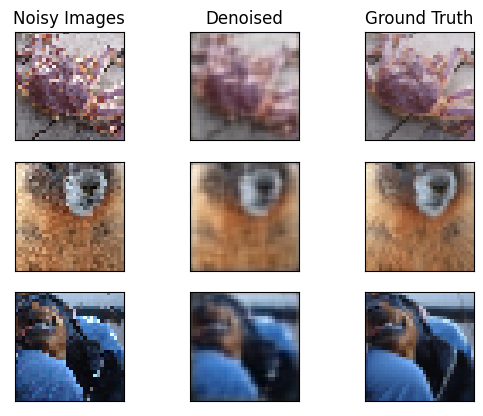

In [24]:
psnr_eval(model, noisy_imgs, clean_imgs, must_randomize=False)

# Training from scratch

In [10]:
model = Model()

In [11]:
model.train(noisy_imgs_1, noisy_imgs_2, num_epochs=5, batch_size=8, num_workers=1)

Epoch [4/5]: 100%|██████████| 6250/6250 [01:14<00:00, 83.64it/s, loss=0.0159]


PSNR result: 23.148725509643555dB


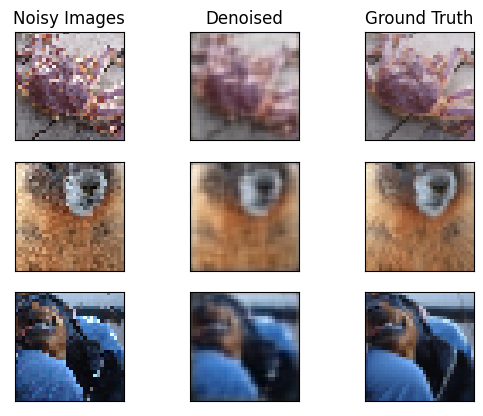

In [25]:
psnr_eval(model, noisy_imgs, clean_imgs, must_randomize=False)

In [ ]:
model.save("model.pth")